# Fine-Tune the System
___

 - You will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
 - As always, automate what you can.
 - Fine-tune the hyperparameters using cross-validation:
 - Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., if you're not sure whether to replace missing values with zeros or with the median value, or to just drop the rows).
 - Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors, as described by Jasper Snoek et al.).
 - Try Ensemble methods. Combining your best models will often produce better performance than running them individually.
 - Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.
 - Warning : Don't tweak your model after measuring the generalization error: you would just start overfitting the test set.

___

Adding Grid Search for Hyperparameter Tuning

___

In [115]:
# Here I use Kaggle to train the model
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/combined-business-data-p4/combined_business_data_p4.pkl
/kaggle/input/combined-business-data-3/combined_business_data_3.pkl
/kaggle/input/combined-business-data-2pkl/combined_business_data_2.pkl


In [116]:
# Install hyperparameter tuner library for keras
!pip install --upgrade keras-hypetune

In [117]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Dropout, AlphaDropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from tensorflow import keras

from kerashypetune import KerasGridSearch, KerasRandomSearchCV, KerasGridSearchCV

# from keras.optimizers import Adam
from keras.regularizers import l2

import math


# Set printing in non scientific notation
np.set_printoptions(suppress=True)


Data

In [118]:
# Data Are now on Kaggle
combined_business_data = pd.read_pickle("/kaggle/input/combined-business-data-p4/combined_business_data_p4.pkl")
combined_business_data.head(2)

,user_id,business_id,stars,date,name,address,user,business
0,nOTl4aPC4tKHK35T3bNauQ,xVEtGucSRLk5pxxN0t4i6g,5.0,2012-08-23,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",4189,1920
1,l0-VQ8nA_oijpKlRB7dkow,xVEtGucSRLk5pxxN0t4i6g,4.0,2010-02-11,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",3989,1920


In [119]:
# Store counts of distinct users and restaurants into variables
n_users = combined_business_data["user"].nunique()
n_rests = combined_business_data["business"].nunique()

# Store min and max stars into a variable
min_rating = min(combined_business_data["stars"])
max_rating = max(combined_business_data["stars"])

print(n_users, n_rests, min_rating, max_rating)

5186 2004 1.0 5.0


In [120]:
# Store inputs into variabe X; store Output into variable y
X = combined_business_data[["user", "business"]].values
y = combined_business_data["stars"].values

print(X.shape, y.shape)

(11591, 2) (11591,)


Split

In [121]:
# Split data into Training and Validation set
X_train_keras, X_val_keras, y_train_keras, y_val_keras = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(X_train_keras.shape, X_val_keras.shape, y_train_keras.shape, y_val_keras.shape)

(9272, 2) (2319, 2) (9272,) (2319,)


In [122]:
# Storing Users and Restaurant into its own array. They will be input separately into the Keras Model
X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_val_array = [X_val_keras[:, 0], X_val_keras[:, 1]]

In [123]:
X_train_array

[array([3527, 3494,  763, ..., 4744, 1615, 2416], dtype=int32),
 array([ 166, 1511, 1972, ...,  480,  870,  918], dtype=int32)]

In [124]:
X_val_array

[array([2068, 1672, 1196, ..., 4855, 2335, 4817], dtype=int32),
 array([ 118, 1293,  235, ...,  291,  974,  788], dtype=int32)]

Choose number of dimensions in embedding space

In [125]:
# Variable that stores number of embedding dimension. Will be tuned as hyperparameter later.
n_embedding_dim = 50

## Model

In [126]:
class EmbeddingLayer:
    '''
    Class to create main section of the model, creating embedding layer followed by the reshape layer.
    '''
    def __init__(self, n_items, n_embedding_dim):
        # ^ vocabulary size, number of categories, or here,
        # ^ number of distinct users or number of distinct restaurants
        self.n_items = n_items

        # ^ encode into how many dimensions?
        # ^ each item(user/restaurant) will be represented as a vector of size n_embedding_dim
        self.n_embedding_dim = n_embedding_dim

    def __call__(self, x):
        x = Embedding(
            input_dim = self.n_items, # number of users/restaurants in a training set
            output_dim = self.n_embedding_dim, # how many dimensions should embedding space contain
            embeddings_initializer="he_normal", # initializer for initial parameter values at the beggining of training
            embeddings_regularizer=l2(1e-6), # regularzation to reduce overfitting
        )(x)
        x = Reshape((self.n_embedding_dim,))(x)
        x = AlphaDropout(0.2)(x)  
        return x


def Recommender(param):
    user = Input(shape=(1,))
    u = EmbeddingLayer(param['n_users'], param['edim'])(user)
    ub = EmbeddingLayer(param['n_users'], 1)(user)  # bias

    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(param['n_rests'], param['edim'])(restaurant)
    mb = EmbeddingLayer(param['n_rests'], 1)(restaurant)  # bias

    x = Dot(axes=1)([u, m]) # Dot product between vector of user and vector of restaurant
    x = Add()([x, ub, mb]) # Adding both bias vectors
    x = Activation(param["activation"])(x)
    x = Lambda(lambda x: x * (param['max_rating'] - param['min_rating']) + param['min_rating'])(x) # Scaling

    model = Model(inputs=[user, restaurant], outputs=x) # Creating the model and specifying input and output
    opt = Adam(learning_rate=param['learning_rate']) # Optimizer algorithm and its learning rate
    model.compile(loss="mean_squared_error", optimizer=opt) # compiling model and specifying loss function

    return model

In [186]:
### Specify the Hyperparameters that will be tried
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# Normally I would add more parameters to search for, but adding few for time constraints for now!!
param_grid = {'n_users':n_users, 
                  'n_rests': n_rests, 
                  'edim': [50, 80, 110], 
                  'min_rating': min_rating,
                  'max_rating': max_rating,
                  'epochs': 30,
                  'learning_rate' : [0.001, 0.01],
                  "activation" : "sigmoid",
                  'batch_size': 32
             }


In [187]:
# # Plot Model
# from keras.utils.vis_utils import plot_model

# plot_model(keras_model, show_shapes=True)


Early Stopping and Saving Checkpoint

In [188]:
# Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

# Callbacks for Saving Checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)


In [189]:
# Traing Model using Grid Search
hypermodel = Recommender

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search([X_train_array[0],X_train_array[1]], y_train_keras, validation_data=([X_val_array[0],X_val_array[1]], y_val_keras), 
           callbacks=[checkpoint_cb, early_stopping_cb]
          )


6 trials detected for ('n_users', 'n_rests', 'edim', 'min_rating', 'max_rating', 'epochs', 'learning_rate', 'activation', 'batch_size')

***** (1/6) *****
Search({'n_users': 5186, 'n_rests': 2004, 'edim': 80, 'min_rating': 1.0, 'max_rating': 5.0, 'epochs': 30, 'learning_rate': 0.01, 'activation': 'sigmoid', 'batch_size': 32})


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


SCORE: 2.06342 at epoch 1

***** (2/6) *****
Search({'n_users': 5186, 'n_rests': 2004, 'edim': 80, 'min_rating': 1.0, 'max_rating': 5.0, 'epochs': 30, 'learning_rate': 0.001, 'activation': 'sigmoid', 'batch_size': 32})
SCORE: 1.78383 at epoch 26

***** (3/6) *****
Search({'n_users': 5186, 'n_rests': 2004, 'edim': 50, 'min_rating': 1.0, 'max_rating': 5.0, 'epochs': 30, 'learning_rate': 0.01, 'activation': 'sigmoid', 'batch_size': 32})
SCORE: 1.97276 at epoch 2

***** (4/6) *****
Search({'n_users': 5186, 'n_rests': 2004, 'edim': 50, 'min_rating': 1.0, 'max_rating': 5.0, 'epochs': 30, 'learning_rate': 0.001, 'activation': 'sigmoid', 'batch_size': 32})
SCORE: 1.75339 at epoch 28

***** (5/6) *****
Search({'n_users': 5186, 'n_rests': 2004, 'edim': 110, 'min_rating': 1.0, 'max_rating': 5.0, 'epochs': 30, 'learning_rate': 0.01, 'activation': 'sigmoid', 'batch_size': 32})
SCORE: 2.07372 at epoch 1

***** (6/6) *****
Search({'n_users': 5186, 'n_rests': 2004, 'edim': 110, 'min_rating': 1.0, 'max

Examine Best Parameters

In [190]:
# Scores from Grid Search
print(kgs.scores)

[2.06342, 1.78383, 1.97276, 1.75339, 2.07372, 1.80955]


In [191]:
# Best Score from Grid Search
print(kgs.best_score)

1.75339


In [192]:
# Best Parameters found
print(kgs.best_params)

{'n_users': 5186, 'n_rests': 2004, 'edim': 50, 'min_rating': 1.0, 'max_rating': 5.0, 'epochs': 28, 'learning_rate': 0.001, 'activation': 'sigmoid', 'batch_size': 32, 'steps_per_epoch': 290}


In [193]:
# Best model is stored here
kgs.best_model

Evaluation

In [194]:
mse_test = kgs.best_model.evaluate(X_val_array, y_val_keras)
print(f"MSE:\n {mse_test}")

73/73 [==============================] - 0s 2ms/step - loss: 1.7559
MSE:
 1.7558850049972534


Prediction

In [195]:
# prediction
predictions = kgs.best_model.predict(X_val_array)
predictions[0:2]

array([[4.126098 ],
       [3.8487973]], dtype=float32)

Examine Predictions

In [196]:
# create table adding prediction results as a column
df_test = pd.DataFrame(X_val_keras[:,0])
df_test.rename(columns={0: "user"}, inplace=True)
df_test['business'] = X_val_keras[:,1]
df_test['stars'] = y_val_keras
df_test["predictions"] = predictions
df_test.head()

,user,business,stars,predictions
0,2068,118,4.0,4.126098
1,1672,1293,5.0,3.848797
2,1196,235,3.0,2.988508
3,3377,744,3.0,3.580831
4,2932,291,4.0,4.645167


In [197]:
# Change label colors of matplotlib
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

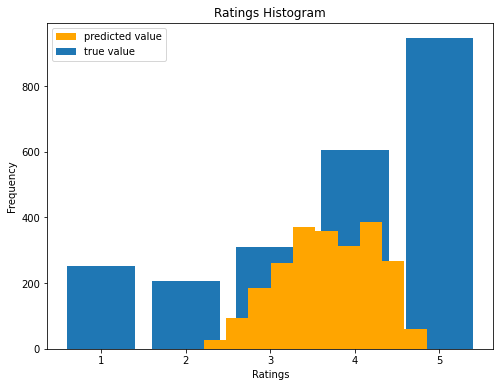

In [198]:
# Plotting the distribution of actual and predicted stars
import matplotlib.pyplot as plt
import seaborn as sns
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Ratings Histogram")
plt.legend()
plt.show()

# For 2 Dimensional Embedding space all predictions are just around 3, which gives big error.

Result

Here I used grid search over several parameter pairs to find best parameters for the model.